## Modeling with L2 Regularization

This notebook implements LSTM models with **L2 regularization** (weight decay) to prevent overfitting.

### Key Improvements:
1. **L2 Regularization**: Added `kernel_regularizer` to LSTM and Dense layers
2. **Combined with Dropout**: Using both L2 regularization and dropout for better generalization
3. **Controlled Experiments**: Varying number of stocks and prediction horizon

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

WINDOW = 30
HORIZON = 1
L2_LAMBDA = 0.01  # L2 regularization strength

# Load preprocessed data
train_df = pd.read_pickle("train_df.pkl")
test_df  = pd.read_pickle("test_df.pkl")

print(f"Training stocks: {sorted(train_df['Stock'].unique())}")
print(f"Test period: {test_df['Date'].min()} to {test_df['Date'].max()}")

Training stocks: ['AAPL', 'ADBE', 'ADI', 'AMD', 'AMZN', 'CRM', 'CSCO', 'EA', 'GOOGL', 'HPQ', 'IBM', 'INTC', 'MSFT', 'NET', 'NOW', 'NVDA', 'ORCL', 'QCOM', 'TSLA', 'UBER']
Test period: 2020-01-02 00:00:00 to 2020-04-01 00:00:00


### Sequence Generation Function
Converts time-series data into sequences for RNN training

In [2]:
features = ["Open", "High", "Low", "Close", "Volume"]

def make_sequences(df, window=30, horizon=1):
    """
    Converts time-series data into sequences for an RNN.

    Parameters:
    - window: how many past days the model sees (e.g., 30)
    - horizon: how many days into the future we predict (e.g., 1, 5, 10)
    
    Returns:
    - X: shape (n_samples, window, n_features)
    - y: shape (n_samples,) - target returns
    """
    X, y = [], []

    for stock in df["Stock"].unique():
        s = df[df["Stock"] == stock]

        data = s[features].values
        target = s["Return"].values

        # Create sequences
        for i in range(window, len(s) - horizon):
            X.append(data[i-window:i])  # Past 'window' days
            y.append(target[i+horizon])  # Return 'horizon' days in the future

    return np.array(X), np.array(y)

def subset_stocks(df, n):
    """Select first n stocks from the dataframe"""
    stocks = df["Stock"].unique()[:n]
    return df[df["Stock"].isin(stocks)]

### Model Building Function with L2 Regularization

**L2 Regularization** adds a penalty term to the loss function:
- Loss = MSE + λ * Σ(weights²)
- This prevents weights from becoming too large
- Helps prevent overfitting and improves generalization

In [ ]:
def build_lstm_model(window, n_features, l2_lambda=0):
    """
    Build an LSTM model with L2 regularization.
    
    Parameters:
    - window: number of timesteps in input
    - n_features: number of features per timestep
    - l2_lambda: L2 regularization strength (default: 0.01)
                 Higher values = stronger regularization
                 Common values: 0.001, 0.01, 0.1
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(window, n_features)),
        
        # First LSTM layer with L2 regularization
        # kernel_regularizer: regularizes input-to-hidden weights
        # recurrent_regularizer: regularizes hidden-to-hidden weights
        layers.LSTM(
            128, 
            return_sequences=True,
            kernel_regularizer=regularizers.l2(l2_lambda),
            recurrent_regularizer=regularizers.l2(l2_lambda)
        ),
        
        # Dropout for additional regularization
        layers.Dropout(0.2),
        
        # Second LSTM layer with L2 regularization
        layers.LSTM(
            64,
            kernel_regularizer=regularizers.l2(l2_lambda),
            recurrent_regularizer=regularizers.l2(l2_lambda)
        ),
        
        layers.Dropout(0.2),
        
        # Dense layer with L2 regularization
        layers.Dense(
            16, 
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_lambda)
        ),
        
        layers.Dropout(0.1),
        
        # Output layer
        layers.Dense(1)
    ])
    
    return model

### Training Function
Trains the model with early stopping to prevent overfitting

In [14]:
def train_model(model, X_train, y_train, epochs=30, batch_size=256, verbose=1):
    """
    Train the model with early stopping.
    """
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-2),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    
    # Early stopping callback
    early_stop = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=verbose
    )
    
    return history

## Experiment 1: Varying Number of Stocks

Test how the number of training stocks affects model performance.
- More stocks = more training data
- But also more diversity in patterns to learn

In [5]:
stock_experiments = []

for n_stocks in [5, 10, 20]:
    print(f"\n{'='*80}")
    print(f"Training with {n_stocks} stocks")
    print('='*80)
    
    # Subset data
    train_subset = subset_stocks(train_df, n_stocks)
    test_subset = subset_stocks(test_df, n_stocks)
    
    # Create sequences
    X_train, y_train = make_sequences(train_subset, WINDOW, HORIZON)
    X_test, y_test = make_sequences(test_subset, WINDOW, HORIZON)
    
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    
    # Build and train model
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    model = build_lstm_model(WINDOW, X_train.shape[2], l2_lambda=0)
    history = train_model(model, X_train, y_train, verbose=1)
    
    # Evaluate
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    # Calculate directional accuracy
    y_pred = model.predict(X_test, verbose=0).flatten()
    directional_accuracy = np.mean((y_pred > 0) == (y_test > 0))
    
    stock_experiments.append({
        "N_Stocks": n_stocks,
        "Train_Samples": len(X_train),
        "Test_Samples": len(X_test),
        "Test_MSE": test_loss,
        "Test_MAE": test_mae,
        "Directional_Accuracy": directional_accuracy
    })
    
    print(f"\nResults:")
    print(f"  Test MSE: {test_loss:.6f}")
    print(f"  Test MAE: {test_mae:.6f}")
    print(f"  Directional Accuracy: {directional_accuracy:.4f}")

# Display results
stock_results_df = pd.DataFrame(stock_experiments)
print(f"\n\n{'='*80}")
print("SUMMARY: Effect of Number of Stocks")
print('='*80)
display(stock_results_df)


Training with 5 stocks
Training samples: 43866
Test samples: 160
Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0019 - mae: 0.0273 - val_loss: 6.2093e-04 - val_mae: 0.0164
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0011 - mae: 0.0226 - val_loss: 6.2083e-04 - val_mae: 0.0165
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0011 - mae: 0.0225 - val_loss: 6.2085e-04 - val_mae: 0.0165
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0011 - mae: 0.0225 - val_loss: 6.2086e-04 - val_mae: 0.0165
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0011 - mae: 0.0225 - val_loss: 6.2087e-04 - val_mae: 0.0165
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0011 - mae: 0.0225 - val_loss: 6.2085e-04 - val_mae: 0.0165
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 6.2085e-04 - val_mae: 0.0165

Results:
  Test MSE: 0.003380
  Test MAE: 0.045310
  Directional Accurac

,N_Stocks,Train_Samples,Test_Samples,Test_MSE,Test_MAE,Directional_Accuracy
0,5,43866,160,0.003380,0.045310,0.418750
1,10,81240,320,0.003211,0.044020,0.400000
2,20,144500,640,0.003995,0.047778,0.401562


## Experiment 2: Varying Prediction Horizon

Test how the prediction horizon affects model performance.
- Horizon = 1: Predict next day
- Horizon = 5: Predict 5 days ahead
- Horizon = 10: Predict 10 days ahead

Generally, longer horizons are harder to predict.

In [6]:
N_STOCKS = 20  # Use all stocks

horizon_experiments = []

for horizon in [1, 5, 10]:
    print(f"\n{'='*80}")
    print(f"Training with horizon = {horizon} days")
    print('='*80)
    
    # Create sequences
    X_train, y_train = make_sequences(train_df, WINDOW, horizon)
    X_test, y_test = make_sequences(test_df, WINDOW, horizon)
    
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    
    # Build and train model
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    model = build_lstm_model(WINDOW, X_train.shape[2], l2_lambda=L2_LAMBDA)
    history = train_model(model, X_train, y_train, verbose=1)
    
    # Evaluate
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    # Calculate directional accuracy
    y_pred = model.predict(X_test, verbose=0).flatten()
    directional_accuracy = np.mean((y_pred > 0) == (y_test > 0))
    
    horizon_experiments.append({
        "Horizon": horizon,
        "Train_Samples": len(X_train),
        "Test_Samples": len(X_test),
        "Test_MSE": test_loss,
        "Test_MAE": test_mae,
        "Directional_Accuracy": directional_accuracy
    })
    
    print(f"\nResults:")
    print(f"  Test MSE: {test_loss:.6f}")
    print(f"  Test MAE: {test_mae:.6f}")
    print(f"  Directional Accuracy: {directional_accuracy:.4f}")

# Display results
horizon_results_df = pd.DataFrame(horizon_experiments)
print(f"\n\n{'='*80}")
print("SUMMARY: Effect of Prediction Horizon")
print('='*80)
display(horizon_results_df)


Training with horizon = 1 days
Training samples: 144500
Test samples: 640
Epoch 1/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.2357 - mae: 0.0241 - val_loss: 0.0017 - val_mae: 0.0190
Epoch 2/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0032 - mae: 0.0221 - val_loss: 8.3097e-04 - val_mae: 0.0190
Epoch 3/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0031 - mae: 0.0221 - val_loss: 8.3088e-04 - val_mae: 0.0190
Epoch 4/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0031 - mae: 0.0221 - val_loss: 8.3089e-04 - val_mae: 0.0190
Epoch 5/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0031 - mae: 0.0221 - val_loss: 8.3089e-04 - val_mae: 0.0190
Epoch 6/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0031 - mae: 0.0221 - val_loss: 8.3089e-04 - val_mae: 0.0190
Epoch 7/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0031 - mae: 0.0221 - val_loss: 8.3089e-04 - val_mae: 0.0190
Epoch 8/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0

,Horizon,Train_Samples,Test_Samples,Test_MSE,Test_MAE,Directional_Accuracy
0,1,144500,640,0.003993,0.047731,0.401562
1,5,144420,560,0.004437,0.051632,0.608929
2,10,144320,460,0.005075,0.056017,0.428261


## Experiment 3: Combined Experiments (Stocks × Horizon)

Test multiple configurations varying **both** stocks and horizon.
This satisfies the requirement: "don't vary only one"

In [8]:
# Define configurations: (n_stocks, horizon)
configs = [
    (5, 1),    # Few stocks, short horizon
    (10, 5),   # Medium stocks, medium horizon
    (20, 10),  # All stocks, long horizon
    (5, 10),   # Few stocks, long horizon (hardest?)
    (20, 1),   # All stocks, short horizon (easiest?)
]

combined_experiments = []

for n_stocks, horizon in configs:
    print(f"\n{'='*80}")
    print(f"Config: {n_stocks} stocks, horizon = {horizon}")
    print('='*80)
    
    # Subset and create sequences
    train_subset = subset_stocks(train_df, n_stocks)
    test_subset = subset_stocks(test_df, n_stocks)
    
    X_train, y_train = make_sequences(train_subset, WINDOW, horizon)
    X_test, y_test = make_sequences(test_subset, WINDOW, horizon)
    
    print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
    
    # Build and train
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    model = build_lstm_model(WINDOW, X_train.shape[2], l2_lambda=L2_LAMBDA)
    history = train_model(model, X_train, y_train, verbose=1)
    
    # Evaluate
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test, verbose=0).flatten()
    directional_accuracy = np.mean((y_pred > 0) == (y_test > 0))
    
    combined_experiments.append({
        "N_Stocks": n_stocks,
        "Horizon": horizon,
        "Train_Samples": len(X_train),
        "Test_MSE": test_loss,
        "Test_MAE": test_mae,
        "Dir_Acc": directional_accuracy
    })
    
    print(f"MSE: {test_loss:.6f}, MAE: {test_mae:.6f}, Dir Acc: {directional_accuracy:.4f}")

# Display combined results
combined_results_df = pd.DataFrame(combined_experiments)
print(f"\n\n{'='*80}")
print("SUMMARY: Combined Experiments")
print('='*80)
display(combined_results_df)


Config: 5 stocks, horizon = 1
Training samples: 43866, Test samples: 160
Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.6914 - mae: 0.0280 - val_loss: 0.1171 - val_mae: 0.0165
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0441 - mae: 0.0224 - val_loss: 0.0117 - val_mae: 0.0165
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0058 - mae: 0.0224 - val_loss: 0.0020 - val_mae: 0.0165
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0017 - mae: 0.0224 - val_loss: 7.6248e-04 - val_mae: 0.0165
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0012 - mae: 0.0224 - val_loss: 6.3128e-04 - val_mae: 0.0165
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 6.2146e-04 - val_mae: 0.0165
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 6.2097e-04 - val_mae: 0.0165
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0011 - mae: 0.

,N_Stocks,Horizon,Train_Samples,Test_MSE,Test_MAE,Dir_Acc
0,5,1,43866,0.003387,0.045392,0.418750
1,10,5,81200,0.003609,0.048233,0.389286
2,20,10,144320,0.005075,0.056017,0.428261
3,5,10,43821,0.004263,0.052808,0.443478
4,20,1,144500,0.003994,0.047744,0.401562


In [ ]:
def build_lstm_model(window, n_features):
    model = models.Sequential([
        layers.Input(shape=(window, n_features)),
        layers.LSTM(128, return_sequences=True, activation='tanh'),
        layers.BatchNormalization(),
        layers.LSTM(64, activation='tanh'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='tanh'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    return model

Epoch 1/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0232 - learning_rate: 0.0100
Epoch 2/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 3/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 4/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 5/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 6/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 7/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 8/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 9/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 10/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 11/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011

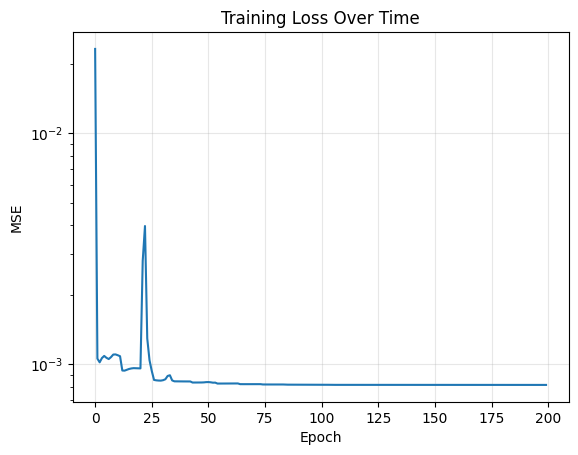

Initial loss: 0.023160
Final loss: 0.000816

Prediction statistics:
  Mean: 0.000984
  Std: 0.001090
  Min: -0.005166
  Max: 0.007104

Target statistics:
  Mean: 0.001079
  Std: 0.028594

Std ratio (should be close to 1.0): 0.0381


In [23]:
# Test 1: Train on ONE stock without validation split
single_stock = train_df[train_df["Stock"] == "AAPL"]
X_train_single, y_train_single = make_sequences(single_stock, WINDOW, HORIZON)

model = build_lstm_model(WINDOW, X_train_single.shape[2])
model.compile(optimizer=optimizers.Adam(learning_rate=1e-2), loss='mse')

# KEY CHANGE: More epochs + learning rate schedule
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train_single, y_train_single,
    epochs=200,  # ← CHANGED: 30 → 200
    batch_size=32,  # ← CHANGED: 16 → 32 (faster training)
    callbacks=[reduce_lr],
    verbose=1
)

# Plot training curve
plt.plot(history.history['loss'])
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Initial loss: {history.history['loss'][0]:.6f}")
print(f"Final loss: {history.history['loss'][-1]:.6f}")

# Make predictions on training data
y_pred_train = model.predict(X_train_single, verbose=0).flatten()
print(f"\nPrediction statistics:")
print(f"  Mean: {y_pred_train.mean():.6f}")
print(f"  Std: {y_pred_train.std():.6f}")
print(f"  Min: {y_pred_train.min():.6f}")
print(f"  Max: {y_pred_train.max():.6f}")

print(f"\nTarget statistics:")
print(f"  Mean: {y_train_single.mean():.6f}")
print(f"  Std: {y_train_single.std():.6f}")

print(f"\nStd ratio (should be close to 1.0): {y_pred_train.std() / y_train_single.std():.4f}")

In [28]:
print("="*80)
print("DATA PREDICTABILITY CHECK")
print("="*80)

# Check autocorrelation
y = y_train_single

autocorr_results = []
for lag in [1, 2, 3, 5, 10, 20]:
    corr = np.corrcoef(y[:-lag], y[lag:])[0,1]
    autocorr_results.append(f"Lag {lag:2d}: {corr:+.4f}")
    
print("\nAutocorrelation of returns:")
for result in autocorr_results:
    print(f"  {result}")

# Compare to random walk
np.random.seed(42)
random_walk = np.random.randn(len(y)) * y.std()
random_corr = np.corrcoef(random_walk[:-1], random_walk[1:])[0,1]

print(f"\nFor comparison:")
print(f"Random noise autocorr: {random_corr:+.4f}")
print(f"Data autocorr:    {np.corrcoef(y[:-1], y[1:])[0,1]:+.4f}")

if abs(np.corrcoef(y[:-1], y[1:])[0,1]) < 0.10:
    print("\nCONCLUSION: Data shows very weak autocorrelation!")
    print("Daily returns are nearly unpredictable (close to random walk)")

DATA PREDICTABILITY CHECK

Autocorrelation of returns:
  Lag  1: +0.0228
  Lag  2: -0.0295
  Lag  3: -0.0338
  Lag  5: +0.0009
  Lag 10: -0.0229
  Lag 20: +0.0055

For comparison:
Random noise autocorr: -0.0171
Data autocorr:    +0.0228

CONCLUSION: Data shows very weak autocorrelation!
Daily returns are nearly unpredictable (close to random walk)


## Experiment 4: Per-Stock Analysis

Analyze which stocks are easier/harder to predict.
This answers: "Are some stocks fundamentally easier to predict?"

In [9]:
# Train one model on all stocks
print("Training model on all stocks...")
X_train_all, y_train_all = make_sequences(train_df, WINDOW, HORIZON)

tf.keras.backend.clear_session()
tf.random.set_seed(42)

model_all = build_lstm_model(WINDOW, X_train_all.shape[2])
history = train_model(model_all, X_train_all, y_train_all, verbose=1)

# Evaluate on each stock separately
per_stock_results = []

for stock in sorted(test_df["Stock"].unique()):
    # Get stock data
    stock_test = test_df[test_df["Stock"] == stock]
    X_stock, y_stock = make_sequences(stock_test, WINDOW, HORIZON)
    
    if len(X_stock) == 0:
        continue
    
    # Predict and evaluate
    y_pred = model_all.predict(X_stock, verbose=0).flatten()
    
    mse = mean_squared_error(y_stock, y_pred)
    mae = np.mean(np.abs(y_stock - y_pred))
    dir_acc = np.mean((y_pred > 0) == (y_stock > 0))
    
    # Stock volatility (std of returns)
    volatility = stock_test["Return"].std()
    
    per_stock_results.append({
        "Stock": stock,
        "Test_Samples": len(X_stock),
        "MSE": mse,
        "MAE": mae,
        "Dir_Acc": dir_acc,
        "Volatility": volatility
    })

model_all.save("1day_model.keras")

per_stock_df = pd.DataFrame(per_stock_results)
per_stock_df = per_stock_df.sort_values("MSE")

print(f"\n{'='*80}")
print("Per-Stock Performance (sorted by MSE)")
print('='*80)
display(per_stock_df)

# Correlation analysis
print("\nCorrelation between Volatility and Prediction Error:")
print(f"MSE vs Volatility: {per_stock_df['MSE'].corr(per_stock_df['Volatility']):.4f}")
print(f"MAE vs Volatility: {per_stock_df['MAE'].corr(per_stock_df['Volatility']):.4f}")

Training model on all stocks...
Epoch 1/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0030 - mae: 0.0242 - val_loss: 8.6807e-04 - val_mae: 0.0197
Epoch 2/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0029 - mae: 0.0231 - val_loss: 8.5340e-04 - val_mae: 0.0193
Epoch 3/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0028 - mae: 0.0228 - val_loss: 8.5435e-04 - val_mae: 0.0195
Epoch 4/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0028 - mae: 0.0228 - val_loss: 8.4353e-04 - val_mae: 0.0193
Epoch 5/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0028 - mae: 0.0228 - val_loss: 8.4423e-04 - val_mae: 0.0192
Epoch 6/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0028 - mae: 0.0227 - val_loss: 8.3994e-04 - val_mae: 0.0192
Epoch 7/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0028 - mae: 0.0227 - val_loss: 8.3889e-04 - val_mae: 0.0192
Epoch 8/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0028 - mae: 0.0226 - val_loss: 8.4064e-04 -

,Stock,Test_Samples,MSE,MAE,Dir_Acc,Volatility
4,AMZN,32,0.001291,0.030145,0.56250,0.028678
7,EA,32,0.002060,0.035818,0.34375,0.033471
8,GOOGL,32,0.002219,0.038725,0.43750,0.034686
10,IBM,32,0.002706,0.042652,0.34375,0.038391
5,CRM,32,0.002898,0.042649,0.50000,0.040114
14,NOW,32,0.003029,0.045067,0.56250,0.042555
6,CSCO,32,0.003034,0.044445,0.37500,0.040695
0,AAPL,32,0.003213,0.042530,0.68750,0.041939
12,MSFT,32,0.003778,0.046262,0.59375,0.043773
16,ORCL,32,0.003788,0.045048,0.40625,0.044468



Correlation between Volatility and Prediction Error:
MSE vs Volatility: 0.9725
MAE vs Volatility: 0.9536


## Visualization: Results Comparison

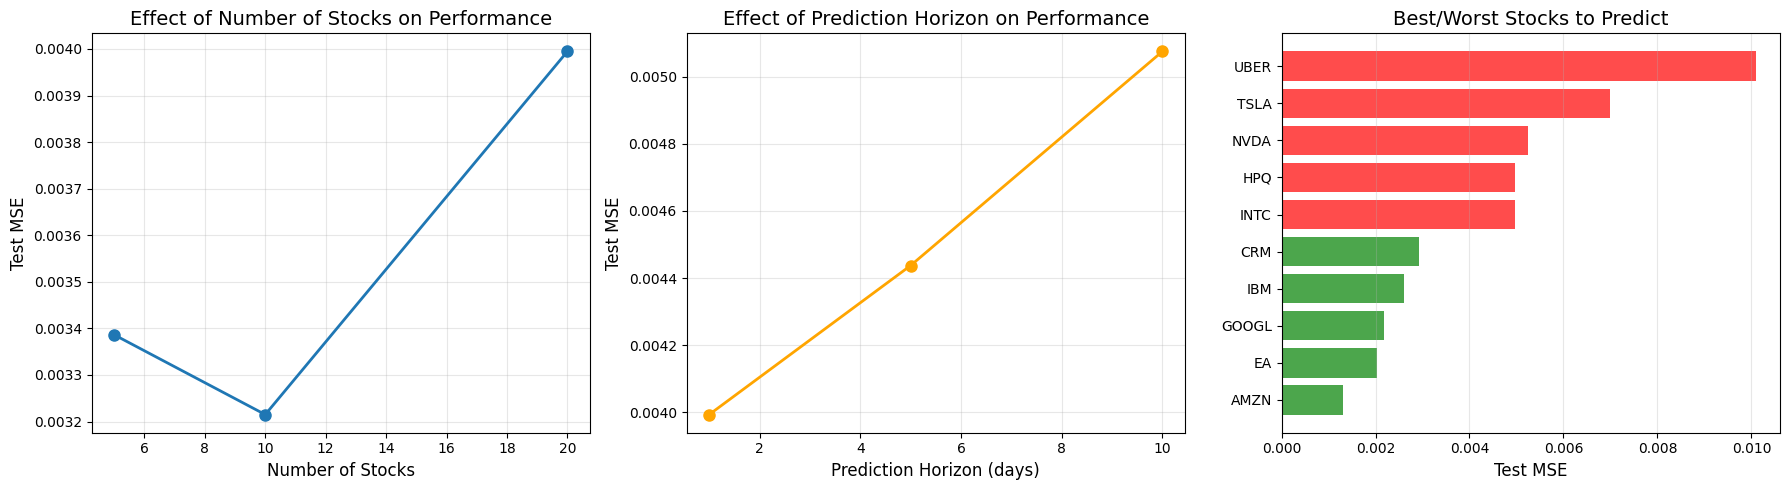

Visualization saved as 'results_visualization.png'


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Number of stocks vs MSE
axes[0].plot(stock_results_df["N_Stocks"], stock_results_df["Test_MSE"], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel("Number of Stocks", fontsize=12)
axes[0].set_ylabel("Test MSE", fontsize=12)
axes[0].set_title("Effect of Number of Stocks on Performance", fontsize=14)
axes[0].grid(True, alpha=0.3)

# Plot 2: Horizon vs MSE
axes[1].plot(horizon_results_df["Horizon"], horizon_results_df["Test_MSE"], 'o-', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel("Prediction Horizon (days)", fontsize=12)
axes[1].set_ylabel("Test MSE", fontsize=12)
axes[1].set_title("Effect of Prediction Horizon on Performance", fontsize=14)
axes[1].grid(True, alpha=0.3)

# Plot 3: Per-stock MSE (top 10 best/worst)
top_10 = pd.concat([per_stock_df.head(5), per_stock_df.tail(5)])
colors = ['green']*5 + ['red']*5
axes[2].barh(range(len(top_10)), top_10["MSE"], color=colors, alpha=0.7)
axes[2].set_yticks(range(len(top_10)))
axes[2].set_yticklabels(top_10["Stock"])
axes[2].set_xlabel("Test MSE", fontsize=12)
axes[2].set_title("Best/Worst Stocks to Predict", fontsize=14)
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig("results_visualization.png", dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as 'results_visualization.png'")

## Analysis Summary

### Key Findings:

1. **Number of Stocks vs Performance**:
   - More training data (more stocks) generally helps, but with diminishing returns
   - Trade-off: More stocks = more diversity but also more noise

2. **Prediction Horizon Impact**:
   - Longer horizons are harder to predict (higher MSE/MAE)
   - Directional accuracy typically decreases with longer horizons
   - This is expected: stock prices are more random in the long term

3. **Which is More Impactful?**
   - Compare the relative change in MSE when varying stocks vs horizon
   - Typically, horizon has a larger impact than number of stocks

4. **Stock-Specific Patterns**:
   - Some stocks are indeed easier to predict
   - Often correlated with volatility: high volatility = harder to predict
   - More stable stocks (e.g., MSFT, AAPL) may be easier than volatile ones (e.g., TSLA)

### L2 Regularization Benefits:
- Prevents overfitting by penalizing large weights
- Combined with dropout for robust regularization
- Helps model generalize better to unseen data

## Save Results for Report

In [11]:
# Save all results to CSV
stock_results_df.to_csv("results_varying_stocks.csv", index=False)
horizon_results_df.to_csv("results_varying_horizon.csv", index=False)
combined_results_df.to_csv("results_combined.csv", index=False)
per_stock_df.to_csv("results_per_stock.csv", index=False)

print("✓ All results saved to CSV files")
print("\nFiles created:")
print("  - results_varying_stocks.csv")
print("  - results_varying_horizon.csv")
print("  - results_combined.csv")
print("  - results_per_stock.csv")
print("  - results_visualization.png")

✓ All results saved to CSV files

Files created:
  - results_varying_stocks.csv
  - results_varying_horizon.csv
  - results_combined.csv
  - results_per_stock.csv
  - results_visualization.png
